In [ ]:
!pip install matplotlib==3.1.3

In [ ]:
!pip install skforecast

In [ ]:
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [ ]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Branch_SalePrice_KARNATAKA.xlsx')
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data = data.set_index('DATE')
data = data.asfreq('D')
data = data.sort_index()
data

,UNIT
DATE,
2012-04-01,45.61
2012-04-02,50.74
2012-04-03,53.38
2012-04-04,54.95
2012-04-05,56.06
...,...
2022-10-06,103.27
2022-10-07,106.47
2022-10-08,111.81


In [ ]:
data.dropna(inplace=True)
data

,UNIT
DATE,
2012-04-01,45.61
2012-04-02,50.74
2012-04-03,53.38
2012-04-04,54.95
2012-04-05,56.06
...,...
2022-10-06,103.27
2022-10-07,106.47
2022-10-08,111.81


In [ ]:
limit = '2022-09-30'
data = data.loc[: limit, :]
data

,UNIT
DATE,
2012-04-01,45.61
2012-04-02,50.74
2012-04-03,53.38
2012-04-04,54.95
2012-04-05,56.06
...,...
2022-09-26,82.94
2022-09-27,78.00
2022-09-28,76.00


In [ ]:
end_train = '2020-09-30'
end_validation = '2021-09-30'

data_train = data.loc[:end_train, :]
data_val = data.loc[end_train:end_validation, :]
data_test = data.loc[end_validation:, :]

print(f'Dates train      : {data_train.index.min()} --- {data_train.index.max()} (n={len(data_train)})')
print(f'Dates validation : {data_val.index.min()} --- {data_val.index.max()} (n={len(data_val)})')
print(f'Dates test       : {data_test.index.min()} --- {data_test.index.max()} (n={len(data_test)})')

Dates train      : 2012-04-01 00:00:00 --- 2020-09-30 00:00:00 (n=3105)
Dates validation : 2020-09-30 00:00:00 --- 2021-09-30 00:00:00 (n=366)
Dates test       : 2021-09-30 00:00:00 --- 2022-09-30 00:00:00 (n=365)


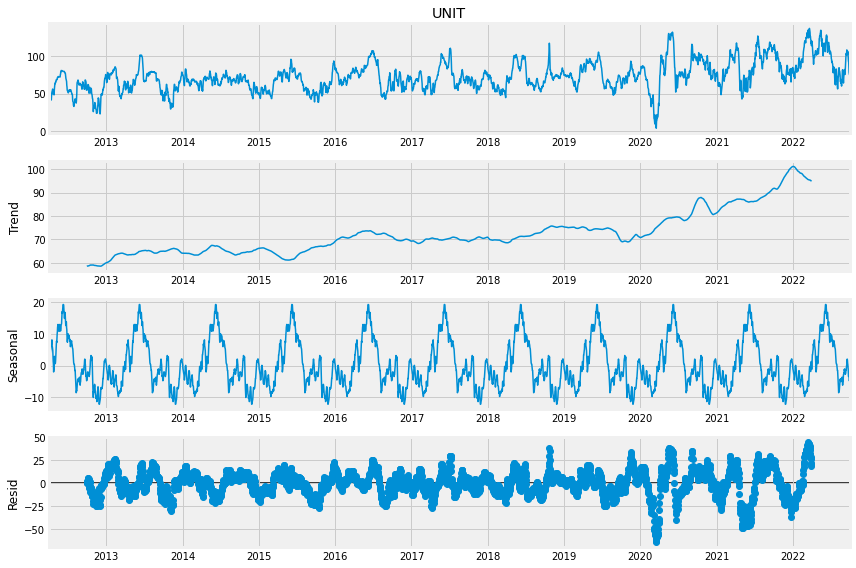

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decompostion = sm.tsa.seasonal_decompose(data.UNIT, model='addictive', freq=365)
fig = decompostion.plot()
plt.show()

In [ ]:
from xgboost.sklearn import XGBRegressor
forecaster = ForecasterAutoreg(
    regressor = XGBRegressor(random_state=123), 
    lags = 365
    )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230

In [ ]:
param_grid = {
    'n_estimators': [250, 500],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.025, 0.05]
    }

# Lags used as predictors
lags_grid = [365, [1, 10, 100, 150, 200, 250, 300, 365]]

results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, 'UNIT'],
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 22,
    refit              = False,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(data_train)),
    return_best        = True,
    verbose            = False
    )

Number of models compared: 24.


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

[11:47:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|███                                  | 1/12 [00:16<02:58, 16.23s/it]

[11:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████▏                              | 2/12 [00:37<03:11, 19.14s/it]

[11:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████▎                           | 3/12 [00:51<02:31, 16.86s/it]

[11:48:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  33%|████████████▎                        | 4/12 [01:22<02:57, 22.23s/it]

[11:48:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████▍                     | 5/12 [01:45<02:39, 22.76s/it]

[11:48:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  50%|██████████████████▌                  | 6/12 [02:32<03:05, 30.99s/it]

[11:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████▌               | 7/12 [02:42<02:00, 24.07s/it]

[11:49:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████▋            | 8/12 [03:02<01:30, 22.64s/it]

[11:50:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████▊         | 9/12 [03:16<01:00, 20.07s/it]

[11:50:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 10/12 [03:45<00:45, 22.85s/it]

[11:50:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 11/12 [04:09<00:23, 23.11s/it]

[11:51:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

[11:52:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|███                                  | 1/12 [00:00<00:04,  2.23it/s]

[11:52:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:06,  1.50it/s]

[11:52:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████▎                           | 3/12 [00:01<00:05,  1.61it/s]

[11:52:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  33%|████████████▎                        | 4/12 [00:02<00:06,  1.25it/s]

[11:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████▍                     | 5/12 [00:03<00:05,  1.21it/s]

[11:52:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:05<00:06,  1.13s/it]

[11:52:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████▌               | 7/12 [00:05<00:04,  1.09it/s]

[11:52:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████▋            | 8/12 [00:06<00:03,  1.12it/s]

[11:52:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:07<00:02,  1.26it/s]

[11:52:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 10/12 [00:08<00:01,  1.12it/s]

[11:52:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:09<00:00,  1.12it/s]

[11:52:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|██████████████████████████████████████| 2/2 [05:10<00:00, 155.46s/it]


[11:52:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1  10 100 150 200 250 300 365] 
  Parameters: {'learning_rate': 0.025, 'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 234.49063726359498



In [ ]:
# Results grid search
# ==============================================================================
results_grid.head(10)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
14,"[1, 10, 100, 150, 200, 250, 300, 365]","{'learning_rate': 0.025, 'max_depth': 3, 'n_es...",234.490637,0.025,3.0,250.0
12,"[1, 10, 100, 150, 200, 250, 300, 365]","{'learning_rate': 0.025, 'max_depth': 2, 'n_es...",244.497732,0.025,2.0,250.0
22,"[1, 10, 100, 150, 200, 250, 300, 365]","{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",244.762526,0.050,5.0,250.0
13,"[1, 10, 100, 150, 200, 250, 300, 365]","{'learning_rate': 0.025, 'max_depth': 2, 'n_es...",245.259434,0.025,2.0,500.0
18,"[1, 10, 100, 150, 200, 250, 300, 365]","{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",251.074333,0.050,2.0,250.0
17,"[1, 10, 100, 150, 200, 250, 300, 365]","{'learning_rate': 0.025, 'max_depth': 5, 'n_es...",253.510353,0.025,5.0,500.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.025, 'max_depth': 2, 'n_es...",256.583899,0.025,2.0,250.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",258.454204,0.050,3.0,500.0
15,"[1, 10, 100, 150, 200, 250, 300, 365]","{'learning_rate': 0.025, 'max_depth': 3, 'n_es...",263.340219,0.025,3.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",269.179472,0.050,2.0,250.0


In [ ]:
# Backeting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['UNIT'],
    initial_train_size = len(data.loc[:end_validation]),
    steps              = 22,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
    )

print(f'Backtest error: {metric}')

[11:52:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:52:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Backtest error: 238.5526918929299


In [ ]:
# Predictions
# ==============================================================================
predictions

,pred
365,108.783035
366,108.726524
367,108.726524
368,108.726524
369,108.766586
...,...
372,106.252892
373,106.177994
374,106.177994
375,106.177994


In [ ]:
pre = pd.DataFrame(predictions)
pre

,pred
365,108.783035
366,108.726524
367,108.726524
368,108.726524
369,108.766586
...,...
372,106.252892
373,106.177994
374,106.177994
375,106.177994


In [ ]:
data_test = data_test.iloc[1:, :]
data_test

,UNIT
DATE,
2021-10-01,109.58
2021-10-02,112.58
2021-10-03,112.09
2021-10-04,115.00
2021-10-05,113.45
...,...
2022-09-26,82.94
2022-09-27,78.00
2022-09-28,76.00


In [ ]:
bf = data_test.join(pre.set_index(data_test.index))
bf

,UNIT,pred
DATE,,
2021-10-01,109.58,108.783035
2021-10-02,112.58,108.726524
2021-10-03,112.09,108.726524
2021-10-04,115.00,108.726524
2021-10-05,113.45,108.766586
...,...,...
2022-09-26,82.94,106.252892
2022-09-27,78.00,106.177994
2022-09-28,76.00,106.177994


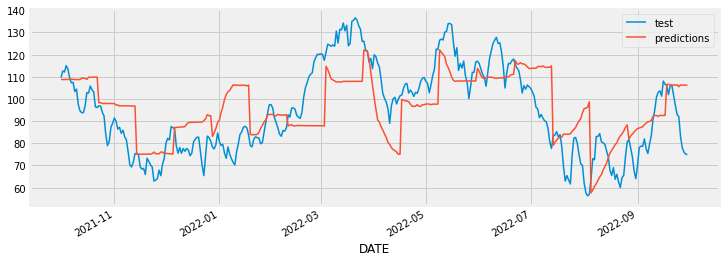

In [ ]:
fig, ax = plt.subplots(figsize=(11, 4))
bf['UNIT'].plot(ax=ax, label='test')
bf['pred'].plot(ax=ax, label='predictions')
ax.legend()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mean_squared_error(bf['UNIT'], bf['pred'])

238.5526918929299

In [ ]:
bf.reset_index(inplace=True)
bf

,DATE,UNIT,pred
0,2021-10-01,109.58,108.783035
1,2021-10-02,112.58,108.726524
2,2021-10-03,112.09,108.726524
3,2021-10-04,115.00,108.726524
4,2021-10-05,113.45,108.766586
...,...,...,...
359,2022-09-26,82.94,106.252892
360,2022-09-27,78.00,106.177994
361,2022-09-28,76.00,106.177994
362,2022-09-29,74.97,106.177994


In [ ]:
monthly_data = bf.resample('M', label='right', on='DATE').sum().reset_index().sort_values(by='DATE')

In [ ]:
monthly_data['UNIT'] = monthly_data['UNIT']/30
monthly_data['pred'] = monthly_data['pred']/30
monthly_data

,DATE,UNIT,pred
0,2021-10-31,102.712667,109.412675
1,2021-11-30,74.195667,84.675678
2,2021-12-31,81.693667,89.448059
3,2022-01-31,84.512667,99.777737
4,2022-02-28,91.702000,83.492390
5,2022-03-31,130.515667,111.850149
6,2022-04-30,104.256667,90.081518
7,2022-05-31,121.430000,111.393599
8,2022-06-30,114.375000,111.631565
9,2022-07-31,85.187000,100.553365


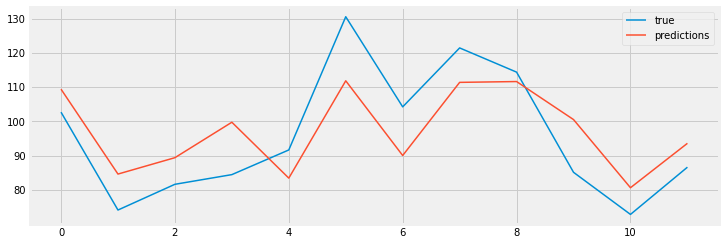

In [ ]:
fig, ax = plt.subplots(figsize=(11, 4))
monthly_data['UNIT'].plot(ax=ax, label='true')
monthly_data['pred'].plot(ax=ax, label='predictions')
ax.legend()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mean_squared_error(monthly_data['UNIT'], monthly_data['pred'])

126.48868058205842

In [ ]:
monthly_data.to_excel('Monthly_KARNATAKA_2022.xlsx')